## Imports

In [ ]:
!pip install torch
!pip install tqdm
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import random
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#!pip install jiwer
import jiwer
from nltk.translate.bleu_score import sentence_bleu


## 2. Configuration

In [ ]:
DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 10
MAX_SEQ_LEN = 128
EMBED_DIM = 256
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
FF_DIM = 512
DROPOUT = 0.1
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


## Normalization

In [ ]:
import re

def normalize_arabic(text):

    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[ًٌٍَُِّْ]", "", text)
    text = re.sub("ـ", "", text)
    return text


## 3. Load Data

In [ ]:
print("Loading data...")

data_limit = 10000


with open('./noisy_articles_10000.json', encoding='utf-8') as f:
    noisy_data = [normalize_arabic(item["text"]) for item in json.load(f)[:data_limit]]

with open('./clean_articles_10000.json', encoding='utf-8') as f:
    clean_data = [normalize_arabic(item["text"]) for item in json.load(f)[:data_limit]]

print(f"Noisy samples: {len(noisy_data)}, Clean samples: {len(clean_data)}")
for i in range(3):
    # Accessing the string directly using index i
    print(f"Clean: {clean_data[i][:50]}...")
    print(f"Noisy: {noisy_data[i][:50]}...")
    print("---")

Loading data...
Noisy samples: 10000, Clean samples: 10000
Clean: قال الدكتور محمد علي فهيم رييس مركز معلومات المناخ...
Noisy: قال الدكتور محمد علي فهيم رييس مركز معلومات المنبخ...
---
Clean: نظمت الهييه القبطيه الانجيليه للخدمات الاجتماعيه و...
Noisy: نجمت الهييه القبطيه انجيليه للخدمات قجلاجتماعيه ار...
---
Clean: لقراينا الراغبين في التعرف علي مواقيت الصلاه الصحي...
Noisy: لقراينا الراغبي نفا التعرف عل يمواقيحت الصلاه الصح...
---


## 4. Tokenizer (char-level)

In [ ]:
print("Building vocabulary...")

# Build character-level vocabulary
all_text = ''.join(noisy_data + clean_data)
vocab = sorted(set(all_text))
vocab = ['<PAD>', '<SOS>', '<EOS>', '<UNK>'] + vocab

char2idx = {ch: idx for idx, ch in enumerate(vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")
print(f"Example chars: {vocab[140:150]}")


Building vocabulary...
Vocab size: 304
Example chars: ['מ', 'ן', 'נ', 'ע', 'ק', 'ר', 'ת', '،', '؛', '\u061c']


## 5. Encode/Decode Functions

In [ ]:
def encode(text, max_len=MAX_SEQ_LEN):
    tokens = [char2idx.get(c, char2idx['<UNK>']) for c in text]
    tokens = [char2idx['<SOS>']] + tokens + [char2idx['<EOS>']]
    if len(tokens) < max_len:
        tokens += [char2idx['<PAD>']] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return torch.tensor(tokens, dtype=torch.long)

def decode(tokens):
    chars = []
    for idx in tokens:
        char = idx2char[idx.item()]
        if char == '<EOS>':
            break
        if char not in ['<PAD>', '<SOS>']:
            chars.append(char)
    return ''.join(chars)

print("Encoding sample...")
print("Original:", clean_data[0][:50])
encoded_sample = encode(clean_data[0])
print("Encoded:", encoded_sample[:10])
print("Decoded:", decode(encoded_sample[:50]))

Encoding sample...
Original: قال الدكتور محمد علي فهيم رييس مركز معلومات المناخ
Encoded: tensor([  1, 172, 152, 174,   7, 152, 174, 159, 173, 154])
Decoded: قال الدكتور محمد علي فهيم رييس مركز معلومات المنا


## 6. Dataset + Dataloader

In [ ]:
class TextDataset(data.Dataset):
    def __init__(self, noisy_texts, clean_texts):
        self.noisy_texts = noisy_texts
        self.clean_texts = clean_texts

    def __len__(self):
        return len(self.noisy_texts)

    def __getitem__(self, idx): #Returns encoded (noisy, clean) pair for a given index
        noisy = encode(self.noisy_texts[idx])
        clean = encode(self.clean_texts[idx])
        return noisy, clean

dataset = TextDataset(noisy_data, clean_data)
train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Dataset and Dataloader ready!")
print("Sample batch:")
for noisy, clean in train_loader:
    print("Noisy shape:", noisy.shape)
    print("Clean shape:", clean.shape)
    break


Dataset and Dataloader ready!
Sample batch:
Noisy shape: torch.Size([32, 128])
Clean shape: torch.Size([32, 128])


## 7. Transformer Model

In [ ]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBED_DIM)
        # Adds position information to each character (since Transformers don’t naturally understand word order).
        self.positional_encoding = nn.Parameter(torch.randn(1, MAX_SEQ_LEN, EMBED_DIM))

        # Takes the noisy input text and understands its meaning
        encoder_layer = nn.TransformerEncoderLayer(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_ENCODER_LAYERS)

        #Takes the encoder’s understanding + previous correct letters to predict the next correct letter.
        decoder_layer = nn.TransformerDecoderLayer(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_DECODER_LAYERS)

        # Converts the decoder’s output into probabilities for each Arabic letter and Picks the best letter	1
        self.fc_out = nn.Linear(EMBED_DIM, vocab_size)

    def forward(self, src, tgt):
        src_emb = self.embedding(src) + self.positional_encoding[:, :src.size(1)]
        tgt_emb = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1)]

        memory = self.encoder(src_emb)
        output = self.decoder(tgt_emb, memory)
        logits = self.fc_out(output)
        return logits

model = Transformer().to(DEVICE)
print("Model initialized!")


Model initialized!


## 8. Training Setup

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3) #Adjusts model weights using adaptive learning rates
criterion = nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>']) #Measures how wrong predictions are
scaler = torch.cuda.amp.GradScaler()

scheduled_sampling_start = 1.0
scheduled_sampling_end = 0.3

def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

<ipython-input-10-b4d2e3aff6a0>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## 9. Training Loop

In [ ]:
train_losses = []
train_accuracies = []
initial_epoch = 0
checkpoint_files = sorted([f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('epoch_')])
if checkpoint_files:
    latest_checkpoint = os.path.join(CHECKPOINT_DIR, checkpoint_files[-1])
    print(f"Found existing checkpoint: {latest_checkpoint}")
    initial_epoch, _ = load_checkpoint(model, optimizer, latest_checkpoint)
    print(f"Resuming training from epoch {initial_epoch + 1}")
print("Starting training...")

for epoch in range(initial_epoch, NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_tokens = 0
    loop = tqdm(train_loader, leave=True)

    # Scheduled Sampling decay
    scheduled_sampling_ratio = scheduled_sampling_start - (epoch / NUM_EPOCHS) * (scheduled_sampling_start - scheduled_sampling_end)

    for src, tgt in loop:  # src=noisy, tgt=clean
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]  # Remove <EOS>
        tgt_output = tgt[:, 1:]# Remove <SOS>

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            src_emb = model.embedding(src) + model.positional_encoding[:, :src.size(1)]
            memory = model.encoder(src_emb)

            decoder_input = tgt[:, :1]  # Start with <SOS>
            outputs = []
            preds = decoder_input  # initialize preds

            for t in range(1, tgt.size(1)):
                tgt_emb = model.embedding(decoder_input) + model.positional_encoding[:, :decoder_input.size(1)]
                out = model.decoder(tgt_emb, memory)
                logit = model.fc_out(out)
                outputs.append(logit[:, -1:, :])  # collect the last output only

                # predict next token
                next_token = logit[:, -1, :].argmax(-1, keepdim=True)  # (batch, 1)

                # Scheduled sampling: sometimes use prediction, sometimes ground truth
                use_pred = (random.random() > scheduled_sampling_ratio)
                next_input = next_token if use_pred else tgt[:, t:t+1]

                decoder_input = torch.cat([decoder_input, next_input], dim=1)

            outputs = torch.cat(outputs, dim=1)  # (batch, seq_len-1, vocab_size)

            loss = criterion(outputs.view(-1, vocab_size), tgt_output.reshape(-1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        preds = outputs.argmax(-1)
        mask = tgt_output != char2idx['<PAD>']
        correct = (preds == tgt_output) & mask
        running_correct += correct.sum().item()
        total_tokens += mask.sum().item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item())



    # Save checkpoint after each epoch
    avg_loss = running_loss / len(train_loader)
    accuracy = running_correct / total_tokens
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    checkpoint_path = f"{CHECKPOINT_DIR}/epoch_{epoch+1}.pt"
    save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")
    print(f"Checkpoint saved to {checkpoint_path}")

print("Training complete!")


Starting training...


  0%|          | 0/313 [00:00<?, ?it/s]<ipython-input-11-55dcaa16538a>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch [1/10]: 100%|██████████| 313/313 [10:03<00:00,  1.93s/it, loss=1.51]


Epoch 1: Loss = 2.2837, Accuracy = 0.3838
Checkpoint saved to ./checkpoints/epoch_1.pt


Epoch [2/10]: 100%|██████████| 313/313 [10:04<00:00,  1.93s/it, loss=0.497]


Epoch 2: Loss = 0.8923, Accuracy = 0.7495
Checkpoint saved to ./checkpoints/epoch_2.pt


Epoch [3/10]: 100%|██████████| 313/313 [10:00<00:00,  1.92s/it, loss=0.33]


Epoch 3: Loss = 0.4202, Accuracy = 0.8957
Checkpoint saved to ./checkpoints/epoch_3.pt


Epoch [4/10]: 100%|██████████| 313/313 [10:07<00:00,  1.94s/it, loss=0.384]


Epoch 4: Loss = 0.3635, Accuracy = 0.9115
Checkpoint saved to ./checkpoints/epoch_4.pt


Epoch [5/10]: 100%|██████████| 313/313 [10:07<00:00,  1.94s/it, loss=0.341]


Epoch 5: Loss = 0.3464, Accuracy = 0.9160
Checkpoint saved to ./checkpoints/epoch_5.pt


Epoch [6/10]: 100%|██████████| 313/313 [10:07<00:00,  1.94s/it, loss=0.403]


Epoch 6: Loss = 0.3437, Accuracy = 0.9169
Checkpoint saved to ./checkpoints/epoch_6.pt


Epoch [7/10]: 100%|██████████| 313/313 [10:04<00:00,  1.93s/it, loss=0.309]


Epoch 7: Loss = 0.3501, Accuracy = 0.9151
Checkpoint saved to ./checkpoints/epoch_7.pt


Epoch [8/10]: 100%|██████████| 313/313 [10:04<00:00,  1.93s/it, loss=0.364]


Epoch 8: Loss = 0.3677, Accuracy = 0.9106
Checkpoint saved to ./checkpoints/epoch_8.pt


Epoch [9/10]: 100%|██████████| 313/313 [10:02<00:00,  1.92s/it, loss=0.565]


Epoch 9: Loss = 0.3895, Accuracy = 0.9047
Checkpoint saved to ./checkpoints/epoch_9.pt


Epoch [10/10]: 100%|██████████| 313/313 [10:07<00:00,  1.94s/it, loss=0.44]

Epoch 10: Loss = 0.4318, Accuracy = 0.8936
Checkpoint saved to ./checkpoints/epoch_10.pt
Training complete!


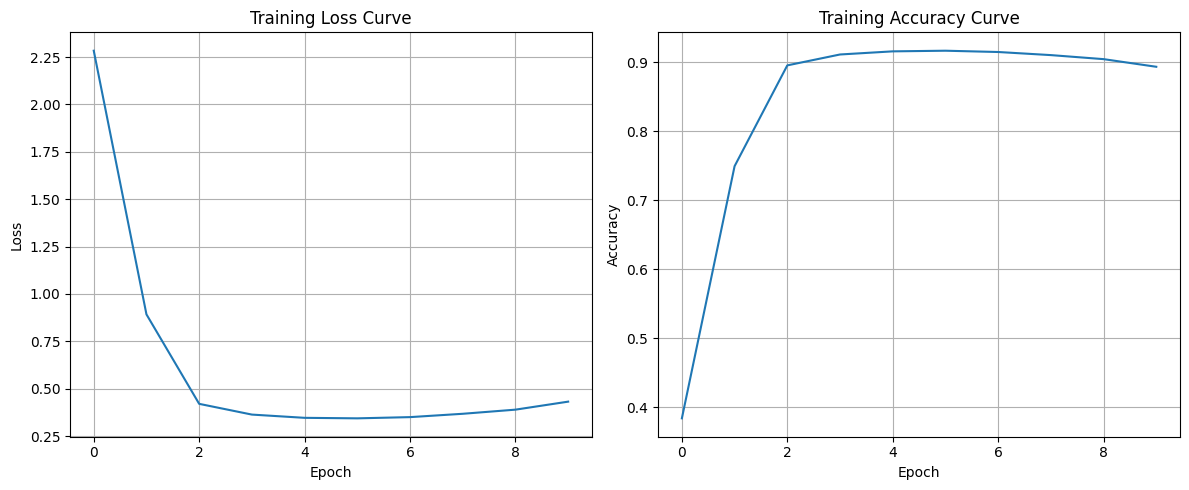

In [ ]:
# After training completes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(initial_epoch, initial_epoch + len(train_losses)), train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(initial_epoch, initial_epoch + len(train_accuracies)), train_accuracies)
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

## 11. Correction and Evaluation Functions

In [ ]:
def correct_text(noisy_text, max_len=100):
    noisy_text = normalize_arabic(noisy_text)  # normalize input text
    model.eval()
    with torch.no_grad():
        # Encode noisy text with <SOS> and <EOS> just like training
        noisy_indices = [char2idx.get(c, char2idx["<UNK>"]) for c in noisy_text]
        noisy_indices = [char2idx["<SOS>"]] + noisy_indices + [char2idx["<EOS>"]]
        if len(noisy_indices) < MAX_SEQ_LEN:
            noisy_indices += [char2idx["<PAD>"]] * (MAX_SEQ_LEN - len(noisy_indices))
        else:
            noisy_indices = noisy_indices[:MAX_SEQ_LEN]

        src = torch.tensor(noisy_indices, dtype=torch.long).unsqueeze(0).to(DEVICE)

        src_emb = model.embedding(src) + model.positional_encoding[:, :src.size(1)]
        memory = model.encoder(src_emb)

        outputs = [char2idx["<SOS>"]]
        for _ in range(max_len):
            tgt_input = torch.tensor(outputs, dtype=torch.long).unsqueeze(0).to(DEVICE)
            tgt_emb = model.embedding(tgt_input) + model.positional_encoding[:, :tgt_input.size(1)]

            output = model.decoder(tgt_emb, memory)
            logits = model.fc_out(output)

            next_token = logits.argmax(-1)[:, -1].item()

            if next_token == char2idx["<EOS>"]:
                break
            outputs.append(next_token)

        corrected_text = ''.join(idx2char[idx] for idx in outputs[1:])  # Remove <SOS>
        return corrected_text
def calculate_cer(ref, hyp):
    return jiwer.cer(ref, hyp)

## 12. Test Cases

In [ ]:
test_samples = [
    ("فذ اطار حرص كلصة الصيدلة", "في اطار حرص كلية الصيدلة"),
    ("المالب يذهب الي المدرسة", "الطالب يذهب الى المدرسة"),
    ("هذا النص صحيح بدون اخطاء", "هذا النص صحيح بدون اخطاء")
]

for noisy, clean in test_samples:
    corrected = correct_text(noisy)
    cer = calculate_cer(clean, corrected)
    print(f"Noisy: {noisy}")
    print(f"Expected: {clean}")
    print(f"Corrected: {corrected}")
    print(f"CER: {cer:.4f}")
    print("="*50)

Noisy: فذ اطار حرص كلصة الصيدلة
Expected: في اطار حرص كلية الصيدلة
Corrected: في اطار حرص كلصه الصيدله
CER: 0.1250
Noisy: المالب يذهب الي المدرسة
Expected: الطالب يذهب الى المدرسة
Corrected: المالب يذهب الي المدرسه
CER: 0.1304
Noisy: هذا النص صحيح بدون اخطاء
Expected: هذا النص صحيح بدون اخطاء
Corrected: tذا النص صحيح بدون اخطاء
CER: 0.0417


In [ ]:
def correct_text2(noisy_text, max_len=200):  # Increased default max_len
    noisy_text = normalize_arabic(noisy_text)
    model.eval()

    with torch.no_grad():
        # Process input in chunks if too long
        if len(noisy_text) > MAX_SEQ_LEN - 2:  # Account for <SOS> and <EOS>
            chunks = [noisy_text[i:i+MAX_SEQ_LEN-2] for i in range(0, len(noisy_text), MAX_SEQ_LEN-2)]
            corrected_chunks = []
            for chunk in chunks:
                corrected_chunks.append(correct_text(chunk))  # Recursive processing
            return ''.join(corrected_chunks)

        # Original processing for shorter texts
        noisy_indices = [char2idx.get(c, char2idx["<UNK>"]) for c in noisy_text]
        noisy_indices = [char2idx["<SOS>"]] + noisy_indices + [char2idx["<EOS>"]]

        if len(noisy_indices) < MAX_SEQ_LEN:
            noisy_indices += [char2idx["<PAD>"]] * (MAX_SEQ_LEN - len(noisy_indices))
        else:
            noisy_indices = noisy_indices[:MAX_SEQ_LEN]

        src = torch.tensor(noisy_indices, dtype=torch.long).unsqueeze(0).to(DEVICE)
        src_emb = model.embedding(src) + model.positional_encoding[:, :src.size(1)]
        memory = model.encoder(src_emb)

        outputs = [char2idx["<SOS>"]]
        for _ in range(min(max_len, MAX_SEQ_LEN)):  # Safety limit
            tgt_input = torch.tensor(outputs, dtype=torch.long).unsqueeze(0).to(DEVICE)
            tgt_emb = model.embedding(tgt_input) + model.positional_encoding[:, :tgt_input.size(1)]

            output = model.decoder(tgt_emb, memory)
            logits = model.fc_out(output)
            next_token = logits.argmax(-1)[:, -1].item()

            if next_token == char2idx["<EOS>"] or len(outputs) >= max_len:
                break
            outputs.append(next_token)

        corrected_text = ''.join(idx2char[idx] for idx in outputs[1:])
        return corrected_text

In [ ]:
test_samples = [
    (noisy_data[0][:110],clean_data[0][:110]),
]

for noisy, clean in test_samples:
    corrected = correct_text2(noisy)
    cer = calculate_cer(clean, corrected)
    print(f"Noisy: \n{noisy}")
    #print(f"Expected: \n{clean}")
    print(f"Corrected:\n {corrected}")
    print(f"CER: {cer:.4f}")
    print("="*50)

Noisy: 
قال الدكتور محمد علي فهيم رييس مركز معلومات المنبخ بوزاره الزراعه واستصلاح ااراضي ان الموعد امناسب ل زراعه الا
Corrected:
 قال الدكتور محمد علي فهيم رييس مركز معلومات المناخ بوزاره الزراعه واستصلاح الاراضي ان الموعد امناسب ل زراعه الاU
CER: 0.0364


## Calculate CER for multiple samples 1

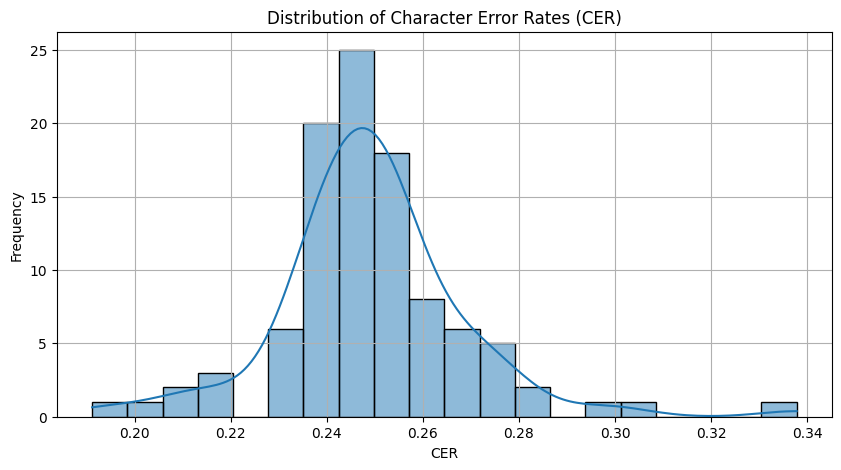

In [ ]:
import seaborn as sns

# Calculate CER for multiple samples
test_samples = list(zip(noisy_data[:100], clean_data[:100]))  # Use first 100 samples
cer_scores = [calculate_cer(clean, correct_text2(noisy)) for noisy, clean in test_samples]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(cer_scores, bins=20, kde=True)
plt.title("Distribution of Character Error Rates (CER)")
plt.xlabel("CER")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Calculate CER for multiple samples 2


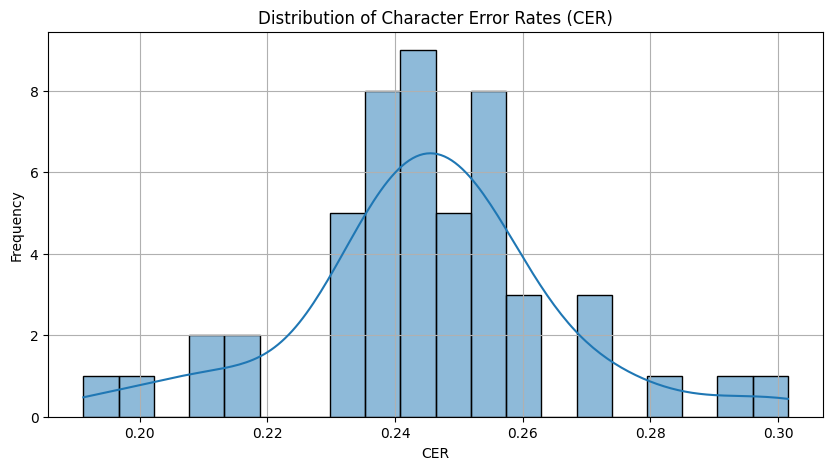

In [ ]:
import seaborn as sns

# Calculate CER for multiple samples
test_samples = list(zip(noisy_data[:100][:50], clean_data[:100][:50]))  # Use first 100 samples
cer_scores = [calculate_cer(clean, correct_text2(noisy)) for noisy, clean in test_samples]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(cer_scores, bins=20, kde=True)
plt.title("Distribution of Character Error Rates (CER)")
plt.xlabel("CER")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

##  Error Type Classification


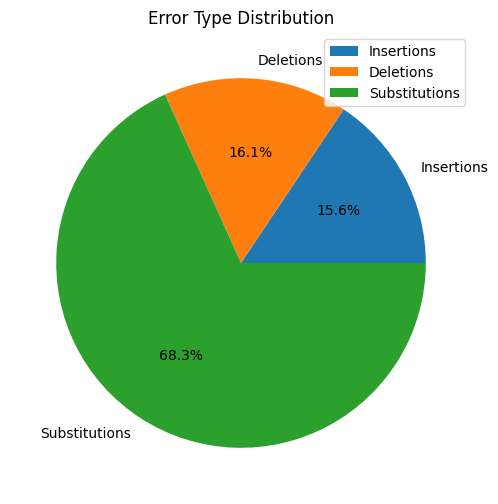

In [ ]:
import pandas as pd

error_types = {
    "Insertions": 0,
    "Deletions": 0,
    "Substitutions": 0
}

for noisy, clean in test_samples[:50]:
    corrected = correct_text(noisy)
    ref = list(clean)
    hyp = list(corrected)

    # Simple alignment-based analysis
    for r, h in zip(ref, hyp):
        if r != h:
            if h == ' ': error_types["Deletions"] += 1
            elif r == ' ': error_types["Insertions"] += 1
            else: error_types["Substitutions"] += 1

pd.DataFrame.from_dict(error_types, orient='index', columns=['Count']).plot.pie(
    y='Count', autopct='%1.1f%%', figsize=(6, 6))
plt.title("Error Type Distribution")
plt.ylabel("")
plt.show()

In [ ]:
test_samples = list(zip(noisy_data[:100][:50], clean_data[:100][:50]))

bleu_scores = []
for noisy, clean in test_samples[:50]:
    corrected = correct_text2(noisy)
    bleu_scores.append(sentence_bleu([clean.split()], corrected.split()))

print(f"Average BLEU Score: {np.mean(bleu_scores):.3f}")

Average BLEU Score: 0.292


## B. Per-Class Accuracy (Confusion Matrix)


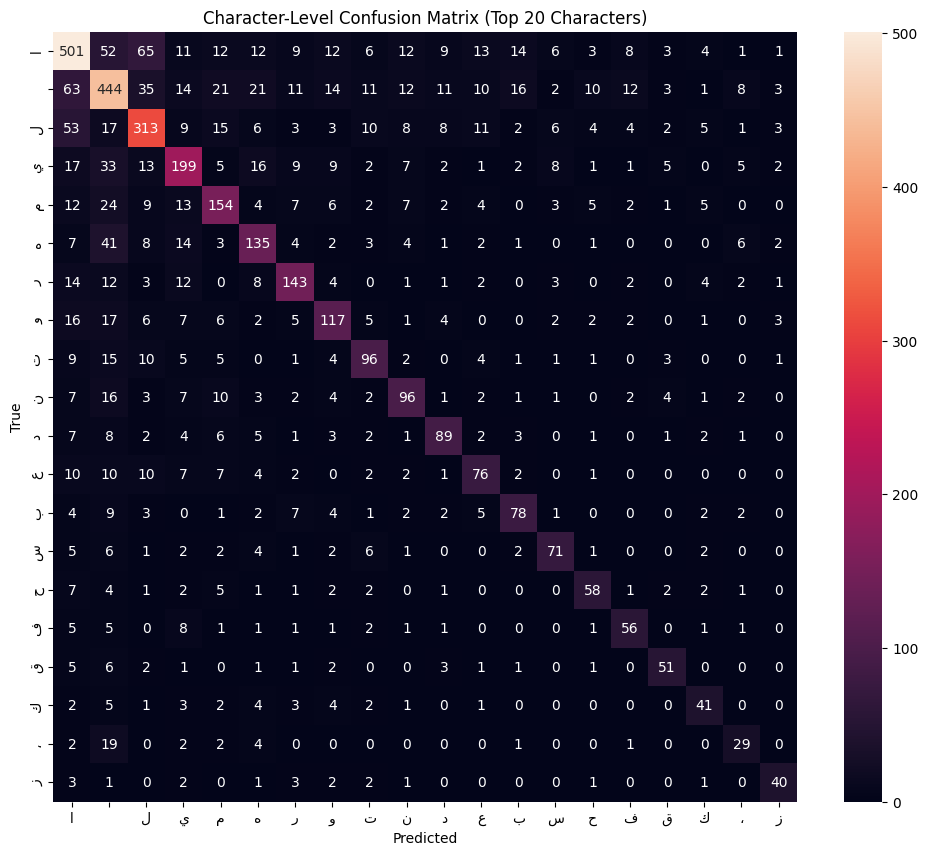

In [ ]:
from sklearn.metrics import confusion_matrix

def get_char_pairs(samples=50):
    pairs = []
    for noisy, clean in test_samples[:samples][:100]:
        corrected = correct_text(noisy)
        for c_true, c_pred in zip(clean, corrected):
            if c_true in char2idx and c_pred in char2idx:
                pairs.append((c_true, c_pred))
    return pairs

pairs = get_char_pairs()
true_chars = [p[0] for p in pairs]
pred_chars = [p[1] for p in pairs]

# Top 20 most common characters
common_chars = sorted(set(true_chars), key=lambda x: true_chars.count(x), reverse=True)[:20]
filtered_pairs = [(t, p) for t, p in zip(true_chars, pred_chars) if t in common_chars]

cm = confusion_matrix([p[0] for p in filtered_pairs], [p[1] for p in filtered_pairs], labels=common_chars)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=common_chars, yticklabels=common_chars)
plt.title("Character-Level Confusion Matrix (Top 20 Characters)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

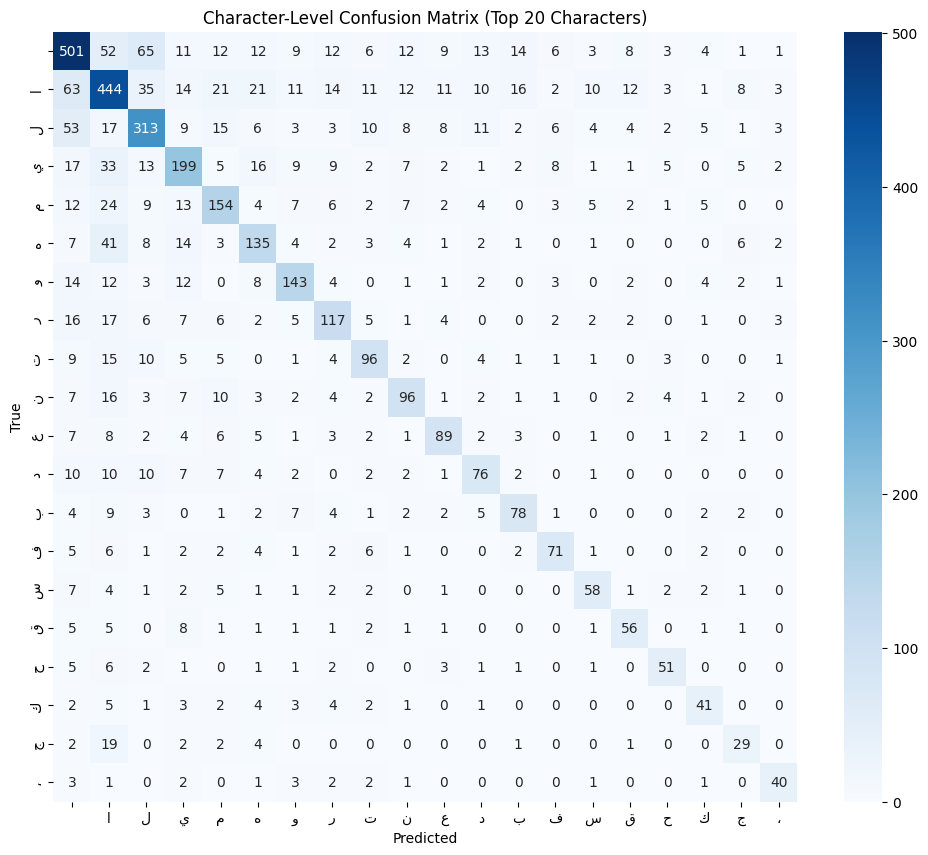

In [ ]:
from collections import Counter

# Get the 20 most common Arabic characters (excluding special tokens)
char_list = [char for char, _ in Counter("".join(clean_data)).most_common(20)
             if char not in ['<PAD>', '<SOS>', '<EOS>', '<UNK>']]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=char_list,
            yticklabels=char_list,
            cmap='Blues')
plt.title("Character-Level Confusion Matrix (Top 20 Characters)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Find top 5 most confused character pairs
confusion_pairs = []
for i, true_char in enumerate(char_list):
    for j, pred_char in enumerate(char_list):
        if i != j and cm[i,j] > 10:  # Only significant errors
            confusion_pairs.append((true_char, pred_char, cm[i,j]))

# Sort by most frequent errors
top_errors = sorted(confusion_pairs, key=lambda x: -x[2])[:5]
print("Top 5 Character Confusions:")
for true, pred, count in top_errors:
    print(f"{true} → {pred}: {count} errors")

Top 5 Character Confusions:
  → ل: 65 errors
ا →  : 63 errors
ل →  : 53 errors
  → ا: 52 errors
ه → ا: 41 errors


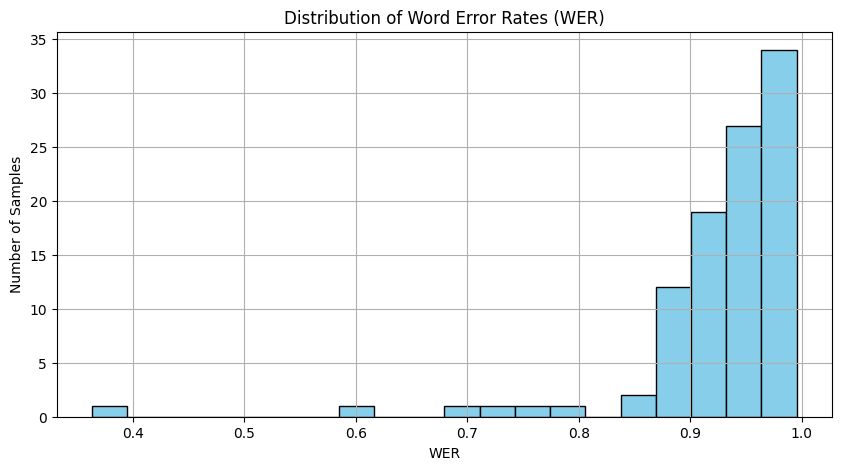

In [ ]:
from jiwer import wer

def safe_wer(clean, noisy):
    """Calculate WER while ensuring equal word counts"""
    clean_words = clean.split()
    corrected_words = correct_text(noisy).split()

    # Pad shorter sequence with empty strings to match lengths
    max_len = max(len(clean_words), len(corrected_words))
    clean_words += [''] * (max_len - len(clean_words))
    corrected_words += [''] * (max_len - len(corrected_words))

    return wer(clean_words, corrected_words)

# Calculate WER for first 100 samples
wer_scores = [safe_wer(clean, noisy)
             for noisy, clean in zip(noisy_data[:100], clean_data[:100])]

# Plot
plt.figure(figsize=(10, 5))
plt.hist(wer_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Word Error Rates (WER)")
plt.xlabel("WER")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

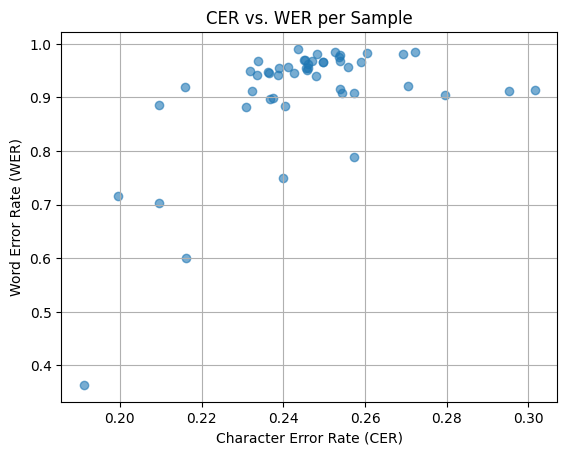

In [ ]:
# Calculate WER for first 50 samples to match CER calculation
wer_scores = [safe_wer(clean, noisy)
             for noisy, clean in zip(noisy_data[:50], clean_data[:50])]

# Now the plot should work correctly
plt.scatter(cer_scores, wer_scores, alpha=0.6)
plt.title("CER vs. WER per Sample")
plt.xlabel("Character Error Rate (CER)")
plt.ylabel("Word Error Rate (WER)")
plt.grid(True)
plt.show()

<Axes: >

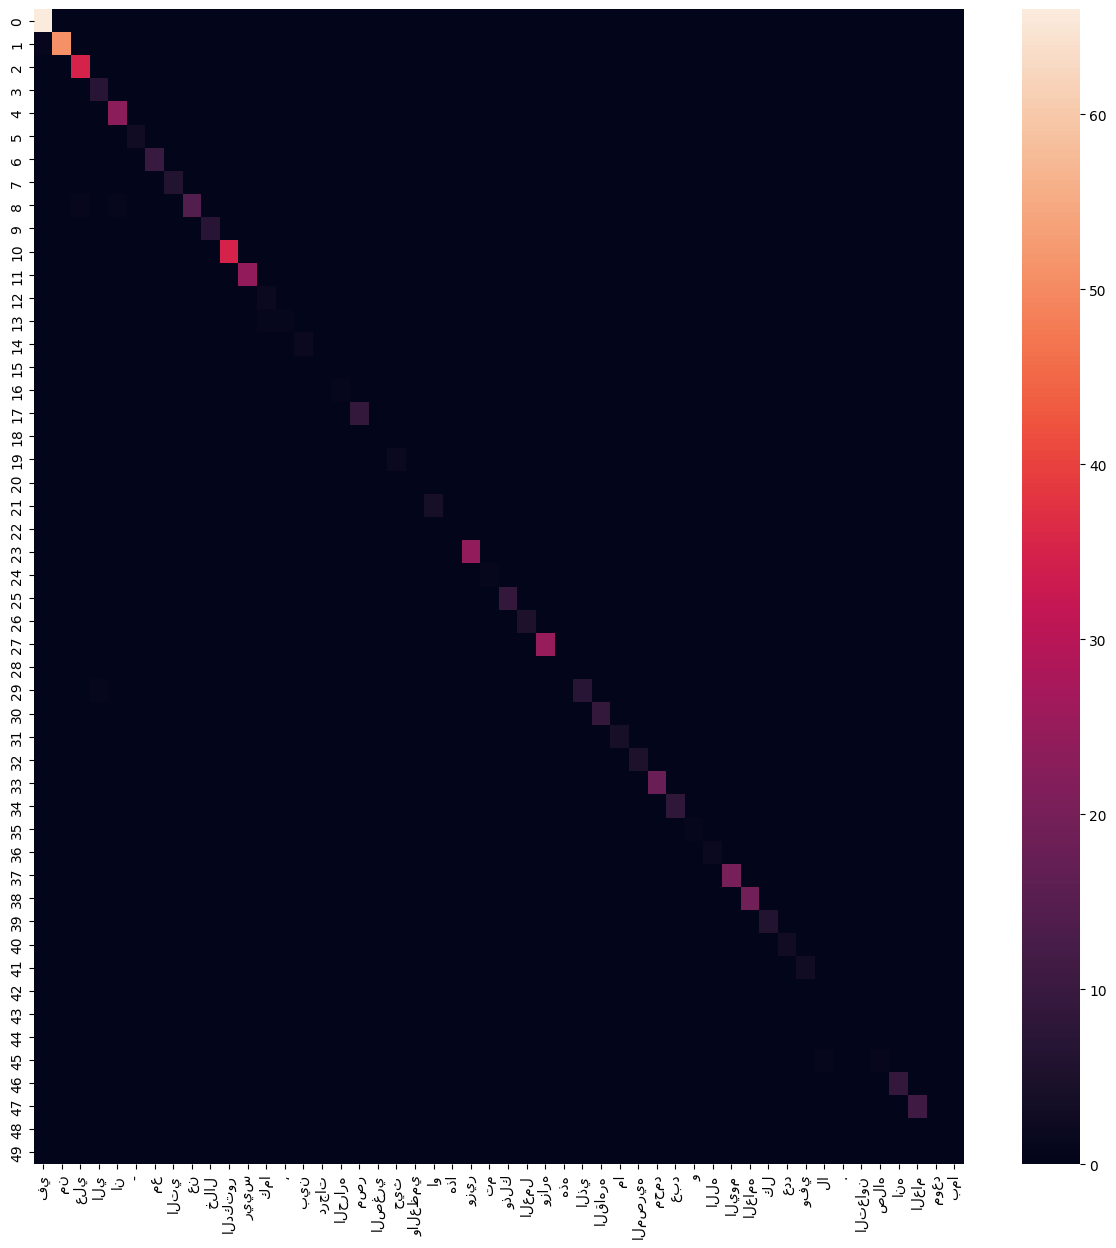

In [ ]:


# Get top 50 frequent words
all_words = ' '.join(clean_data).split()
top_words = [word for word, _ in Counter(all_words).most_common(50)]

# Generate predictions and truths
y_true = []; y_pred = []
for noisy, clean in zip(noisy_data[:200], clean_data[:200]):
    # Ensure both lists have the same number of words after correction
    corrected_text_words = correct_text(noisy).split()
    clean_text_words = clean.split()
    min_len = min(len(corrected_text_words), len(clean_text_words))  # Get the minimum length

    y_true.extend(clean_text_words[:min_len])  # Use only the matching words
    y_pred.extend(corrected_text_words[:min_len])  # Use only the matching words

# Filter for top words
# Get top 50 frequent words
all_words = ' '.join(clean_data).split()
top_words = [word for word, _ in Counter(all_words).most_common(50)]

# Generate predictions and truths
y_true = []; y_pred = []
for noisy, clean in zip(noisy_data[:200], clean_data[:200]):
    # Ensure both lists have the same number of words after correction
    corrected_text_words = correct_text(noisy).split()
    clean_text_words = clean.split()
    min_len = min(len(corrected_text_words), len(clean_text_words))  # Get the minimum length

    y_true.extend(clean_text_words[:min_len])  # Use only the matching words
    y_pred.extend(corrected_text_words[:min_len])  # Use only the matching words

# Filter for top words
cm = confusion_matrix(y_true, y_pred, labels=top_words)



<Axes: >

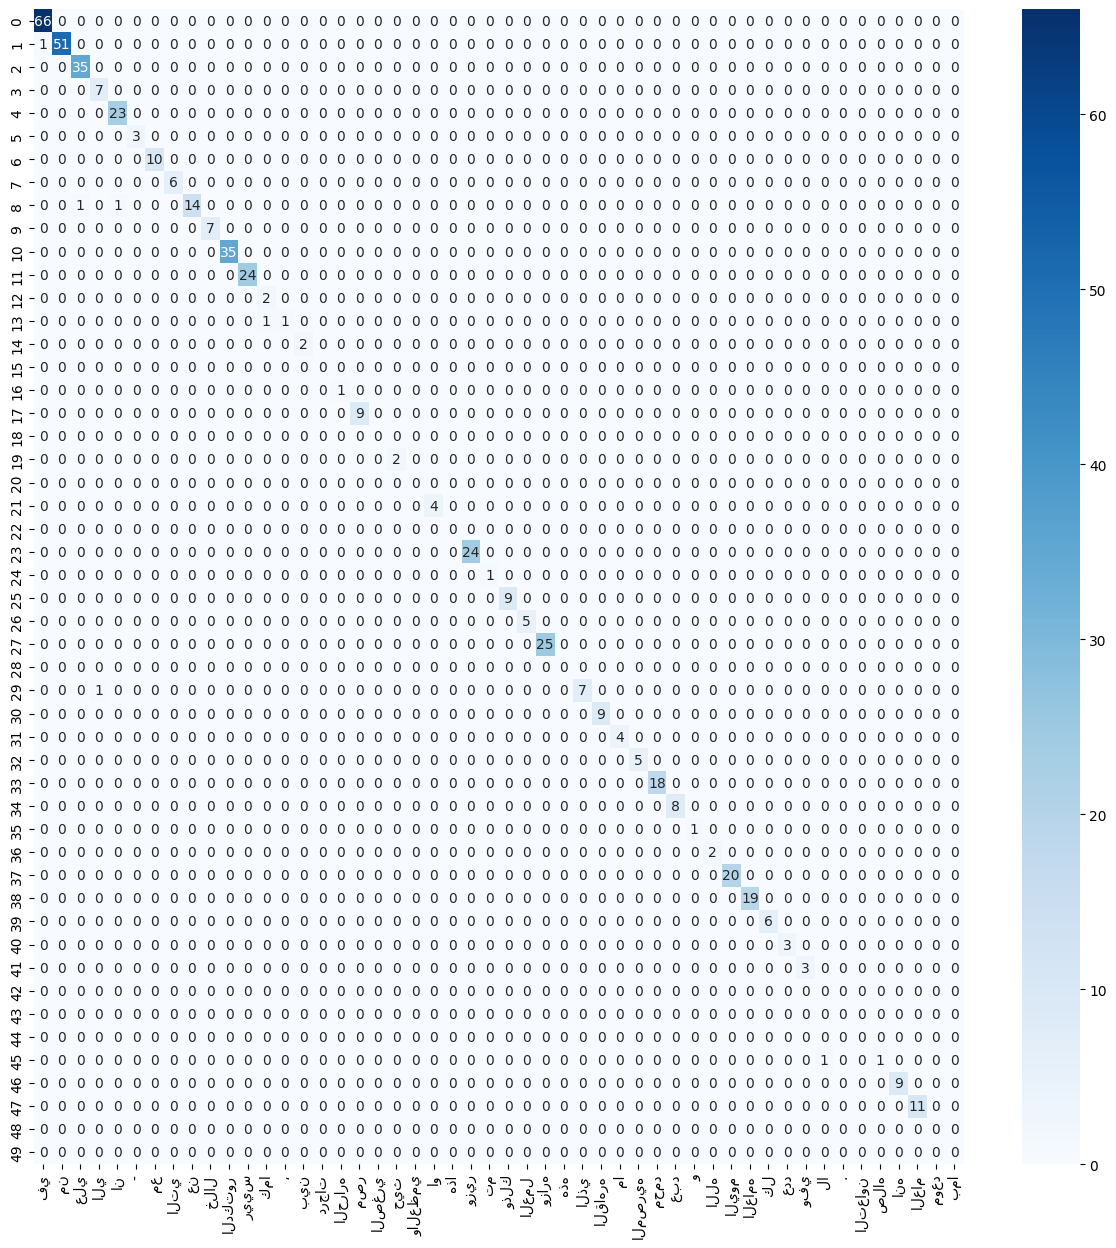

In [ ]:
# Plot
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, xticklabels=top_words,fmt="d",cmap='Blues')